In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, ExponentialFitter
import seaborn as sns
import os


# Create output directory for figures if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the dataset
df = pd.read_csv('Cell1.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
display(df.head())

# Check for missing values in key columns
print("\nMissing values in key columns:")
display(df[['churn', 'months']].isnull().sum())

# Basic statistics of key variables
print("\nBasic statistics of key variables:")
display(df[['churn', 'months', 'totmrc_Mean', 'mou_Mean', 'rev_Mean', 'ovrmou_Mean']].describe())

Dataset shape: (100000, 173)


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,rev_Range,...,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,car_buy,retdays,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,25.99,...,U,U,U,U,U,Y,New,23.0,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,153.14,...,U,U,U,U,U,Y,UNKNOWN,NaN,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,Y,U,U,U,Y,New,NaN,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,Y,U,U,U,U,Y,New,NaN,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,U,U,U,U,Y,New,NaN,434.0,1000005



Missing values in key columns:


churn     0
months    0
dtype: int64


Basic statistics of key variables:


,churn,months,totmrc_Mean,mou_Mean,rev_Mean,ovrmou_Mean
count,100000.000000,100000.000000,99643.000000,99643.000000,99643.000000,99643.000000
mean,0.495620,18.833990,46.179136,513.559937,58.719985,41.072247
std,0.499983,9.655794,23.623489,525.168140,46.291677,97.296150
min,0.000000,6.000000,-26.915000,0.000000,-6.167500,0.000000
25%,0.000000,11.000000,30.000000,150.750000,33.260000,0.000000
50%,0.000000,16.000000,44.990000,355.500000,48.195000,2.750000
75%,1.000000,24.000000,59.990000,703.000000,70.750000,42.000000
max,1.000000,61.000000,409.990000,12206.750000,3843.262500,4320.750000


# EDA 


Churn distribution:
churn
0    50438
1    49562
Name: count, dtype: int64
Churn rate: 49.56%


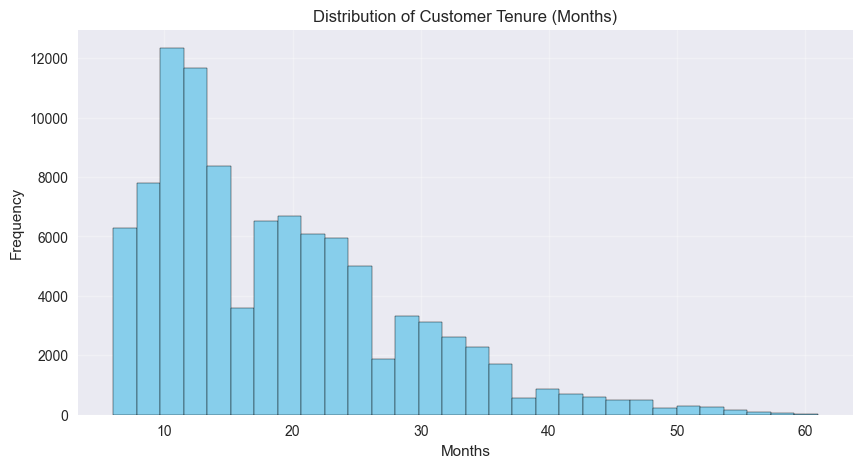

In [3]:
# Check churn distribution
churn_counts = df['churn'].value_counts()
print(f"\nChurn distribution:\n{churn_counts}")
print(f"Churn rate: {churn_counts[1] / len(df):.2%}")

# Visualize months distribution
plt.figure(figsize=(10, 5))
plt.hist(df['months'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Tenure (Months)')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
#plt.savefig('figures/tenure_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()



In [4]:
# columns = df.columns
# # Print columns in a list format for better readability
# print("List of columns in the DataFrame:")
# column_list = list(columns)
# for i, col in enumerate(column_list):
#     print(f"{i+1}. {col}")

In [5]:
# Create a function to analyze both missing values and rare categories
def analyze_columns(df):
    # Create a dataframe for missing values
    missing_df = pd.DataFrame({
        'column_name': df.columns,
        'missing_pct': (df.isnull().sum() / len(df) * 100).round(2)
    })
    
    # Function to check for rare categories (less than 5%)
    def rare_categories(col):
        if df[col].dtype == 'object' or df[col].nunique() < 20:  # Only for categorical or low-cardinality columns
            value_counts = df[col].value_counts(normalize=True) * 100
            rare_values = value_counts[value_counts < 5].index.tolist()
            if rare_values:
                return ', '.join([f"{v} ({value_counts[v]:.2f}%)" for v in rare_values])
            return "None"
        return "N/A (numeric/high-cardinality)"
    
    # Add unique values count and rare categories
    missing_df['unique_values'] = [df[col].nunique() for col in df.columns]
    missing_df['rare_categories'] = [rare_categories(col) for col in df.columns]
    
    return missing_df.sort_values('missing_pct', ascending=False)

# Call the function
column_analysis = analyze_columns(df)
display(column_analysis)

,column_name,missing_pct,unique_values,rare_categories
mailflag,mailflag,98.52,2,Y (1.29%)
solflag,solflag,98.04,2,Y (1.07%)
crtcount,crtcount,96.50,16,"3.0 (4.91%), 4.0 (1.94%), 5.0 (1.34%), 7.0 (0...."
tot_ret,tot_ret,96.02,5,"3.0 (0.73%), 4.0 (0.08%), 5.0 (0.03%)"
tot_acpt,tot_acpt,96.02,5,"2.0 (2.01%), 3.0 (0.28%), 4.0 (0.03%)"
...,...,...,...,...
avgqty,avgqty,0.00,34704,N/A (numeric/high-cardinality)
avgmou,avgmou,0.00,57931,N/A (numeric/high-cardinality)
avgrev,avgrev,0.00,14863,N/A (numeric/high-cardinality)
eqpdays,eqpdays,0.00,1555,N/A (numeric/high-cardinality)


In [6]:
# Filter to show only columns with more than 50% missing values
high_missing_columns = column_analysis[column_analysis['missing_pct'] > 3]
#display(high_missing_columns)

## Cleaning & Imputation

In [7]:
# drop MAILFLAG, and MAILORDR and create new column 'mail' if na = 0 else 1
# last_swap becomes 'phoneswap' binary if na = 0 else 1
# tot_ret becomes 'retentioncall' binary if na = 0 else 1
# tot_acpt becomes 'acptcall' binary if na = 0 else 1
# REF_QTY becomes 'referrals' if na = 0 else 1
# pcowner becomes 'pcowner' binary if na = 0 else 1
# wrkwoman becomes 'women' binary if na = 0 else 1

# mailordr becomes 'mailordr' binary if na = 0 else 1
# mailresp becomes 'mailresp' binary if na = 0 else 1
# rmmou if na fill with 0
# drop solflag, pre_hnd_price, crtcount, retdays, educ1, rmrev, div_type, occu1, proptype, cartype, children, pre_hnd_price  



# numbcars fill na with 0
# adults fill na with 0
# ownrent fill na with "Unknown"
# dwlltype fill na with "Unknown"
# hnd_webcap fill na with "UNKW"
# drop dwllsize, HHstatin, lor, infobase, prizm_social_one


In [8]:
# Create binary features based on missing values
df['mail'] = (~df['mailflag'].isna()).astype(int)
df['phoneswap'] = (~df['last_swap'].isna()).astype(int)
df['retentioncall'] = (~df['tot_ret'].isna()).astype(int)
df['acptcall'] = (~df['tot_acpt'].isna()).astype(int)
df['referrals'] = (~df['REF_QTY'].isna()).astype(int)

# Create binary features for pcowner, wrkwoman, mailordr, mailresp
df['pcowner_binary'] = (~df['pcowner'].isna()).astype(int)
df['women'] = (~df['wrkwoman'].isna()).astype(int)
df['mailordr_binary'] = (~df['mailordr'].isna()).astype(int)
df['mailresp_binary'] = (~df['mailresp'].isna()).astype(int)

# Fill rmmou missing values with 0
df['rmmou'] = df['rmmou'].fillna(0)

# Drop specified columns
columns_to_drop = [
    'mailflag', 'mailordr', 'solflag', 'pre_hnd_price', 'crtcount', 
    'retdays', 'educ1', 'rmrev', 'div_type', 'occu1', 'proptype', 
    'cartype', 'children', 'last_swap', 'tot_ret', 'tot_acpt', 
    'REF_QTY', 'pcowner', 'wrkwoman', 'mailresp'
]

# Remove duplicates from columns_to_drop list
columns_to_drop = list(set(columns_to_drop))

# Drop columns only if they exist in the dataframe
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Fill numeric columns with 0
df['numbcars'] = df['numbcars'].fillna(0)
df['adults'] = df['adults'].fillna(0)

# Fill categorical columns with specified values
df['ownrent'] = df['ownrent'].fillna("Unknown")
df['dwlltype'] = df['dwlltype'].fillna("Unknown")
df['hnd_webcap'] = df['hnd_webcap'].fillna("UNKW")
df['rmcalls'] = df['rmcalls'].fillna(0)
income_median = df['income'].median()
df['income'] = df['income'].fillna(income_median)

# Drop specified columns
columns_to_drop = ['dwllsize', 'HHstatin', 'lor', 'infobase', 'prizm_social_one']

# Drop columns only if they exist in the dataframe
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])


# Print info after cleaning
print(f"DataFrame shape after cleaning: {df.shape}")

DataFrame shape after cleaning: (100000, 157)


In [9]:
column_analysis = analyze_columns(df)
high_missing_columns = column_analysis[column_analysis['missing_pct'] > 0]
#display(high_missing_columns.head())

In [10]:
import missingno as mg

df = df.dropna()

# missing_cols = df.columns[df.isnull().mean() > 0]
# mg.matrix(df[missing_cols], figsize=(12, 6))
# plt.title('Missing Values Matrix')
# plt.show()

# Outliers


In [11]:
numeric_df = df.select_dtypes(include=[np.number])
print("\nBasic statistics of numerical columns with a min of negative values:")
display(numeric_df.describe().loc[:, (numeric_df < 0).any(axis=0)])


Basic statistics of numerical columns with a min of negative values:


,rev_Mean,totmrc_Mean,change_mou,change_rev,avg6rev,eqpdays
count,93893.000000,93893.000000,93893.000000,93893.000000,93893.000000,93893.000000
mean,58.423914,46.087681,-14.316169,-1.047258,58.430714,399.203860
std,46.060506,23.436493,273.056957,50.650086,40.392765,254.744302
min,-5.862500,-26.915000,-3406.500000,-1107.740000,-2.000000,-5.000000
25%,33.240000,30.000000,-86.250000,-7.207500,34.000000,224.000000
50%,47.915000,44.990000,-6.500000,-0.307500,49.000000,350.000000
75%,70.272500,59.990000,61.500000,1.530000,70.000000,539.000000
max,3843.262500,409.990000,31219.250000,9963.657500,866.000000,1823.000000


In [12]:
# Replace negative values with 0 in specified columns
cols_to_replace = ['rev_Mean', 'totmrc_Mean', 'avg6rev', 'eqpdays']

# Store counts of how many values are replaced
replacement_counts = {}

for col in cols_to_replace:
    if col in df.columns:
        # Count negative values
        neg_count = (df[col] < 0).sum()
        replacement_counts[col] = neg_count
        
        # Replace negative values with 0
        df[col] = df[col].clip(lower=0)

# Print summary of replacements
for col, count in replacement_counts.items():
    print(f"Replaced {count} negative values with 0 in column '{col}'")

Replaced 1 negative values with 0 in column 'rev_Mean'
Replaced 17 negative values with 0 in column 'totmrc_Mean'
Replaced 3 negative values with 0 in column 'avg6rev'
Replaced 89 negative values with 0 in column 'eqpdays'


In [13]:
# Create a DataFrame with data types and unique values information
dtype_df = pd.DataFrame({
    'column_name': df.columns,
    'data_type': df.dtypes.values,
    'unique_count': [df[col].nunique() for col in df.columns]
})

# Function to get unique values for columns with less than 10 unique values
def get_unique_values(col):
    if df[col].nunique() < 10:
        return sorted(df[col].unique().tolist())
    return "More than 10 unique values"

# Add unique values column
dtype_df['unique_values'] = [get_unique_values(col) for col in df.columns]

# Sort by data type and then column name
dtype_df = dtype_df.sort_values(['data_type', 'column_name'])

# Display the DataFrame
display(dtype_df)

,column_name,data_type,unique_count,unique_values
147,Customer_ID,int64,93893,More than 10 unique values
151,acptcall,int64,2,"[0, 1]"
97,actvsubs,int64,12,More than 10 unique values
108,adjqty,int64,12000,More than 10 unique values
90,attempt_Range,int64,945,More than 10 unique values
...,...,...,...,...
141,kid6_10,object,2,"[U, Y]"
131,marital,object,5,"[A, B, M, S, U]"
98,new_cell,object,3,"[N, U, Y]"
129,ownrent,object,3,"[O, R, Unknown]"


In [14]:
print("Original shape:", df.shape)


Original shape: (93893, 157)


In [15]:
# If binary, convert to boolean

for col in df.select_dtypes(include='number').columns:
    unique_vals = df[col].dropna().unique()
    if set(unique_vals).issubset({0, 1}):
        df[col] = df[col].astype(bool)

In [16]:
# Drop columns with 'range' in their name
df = df.loc[:, ~df.columns.str.contains('Range')]


# Identify columns with 'change' in their name
change_cols = df.columns[df.columns.str.contains('change')]

# Drop rows where any 'change' column is outside the range [-100, 100]
mask = (df[change_cols] >= -100) & (df[change_cols] <= 100)
df = df[mask.all(axis=1)]


In [17]:
zero_dominant_cols = []

# Select only numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    if (df[col] == 0).sum() / len(df) >= 0.90:
        zero_dominant_cols.append(col)

print("Columns with ≥90% zeros:")
print(zero_dominant_cols)
print(len(zero_dominant_cols))

for col in zero_dominant_cols:
    df[col] = df[col].apply(lambda x: 0 if x == 0 else 1)  # Step 1: Convert non-zero to 1
    df[col] = df[col].astype(bool)                         # Step 2: Convert to boolean



Columns with ≥90% zeros:
['datovr_Mean', 'drop_dat_Mean', 'blck_dat_Mean', 'unan_dat_Mean', 'recv_sms_Mean', 'comp_dat_Mean', 'mou_cdat_Mean', 'peak_dat_Mean', 'mou_pead_Mean', 'opk_dat_Mean', 'mou_opkd_Mean', 'callfwdv_Mean']
12


In [18]:
from scipy.stats import skew


# Compute skewness for each numeric column
skewness = df.select_dtypes(include='number').apply(skew)

# Sort in descending order
skewness_sorted = skewness.sort_values(ascending=False)

# Print the sorted skewness
print("Skewness by column (descending):")
# Filter skewness values where skewness < -1 or > 1
highly_skewed = skewness_sorted[(skewness_sorted < -6) | (skewness_sorted > 5.9)]

print("Columns with high skewness (skewness < -6 or > 0.59):")
display(highly_skewed)


Skewness by column (descending):
Columns with high skewness (skewness < -6 or > 0.59):


uniqsubs           78.223340
rmmou              34.957556
plcd_dat_Mean      31.752323
rmcalls            31.012965
custcare_Mean      24.848653
roam_Mean          16.311724
threeway_Mean      15.723639
callwait_Mean      14.446644
blck_vce_Mean      12.013365
ccrndmou_Mean      11.185545
cc_mou_Mean        10.736339
actvsubs            9.933685
ovrmou_Mean         8.228333
mouiwylisv_Mean     7.350830
da_Mean             6.730400
inonemin_Mean       6.650511
drop_blk_Mean       6.642931
ovrrev_Mean         6.497064
vceovr_Mean         6.453600
adjqty              6.173942
totcalls            6.124331
dtype: float64

# VIF

In [19]:
# import pandas as pd
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.preprocessing import StandardScaler

# # Select only numeric columns (exclude target if needed)
# X = df.select_dtypes(include='number').dropna()

# # Optional: standardize features for better VIF stability
# X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# # Calculate VIF
# vif_data = pd.DataFrame()
# vif_data['feature'] = X_scaled.columns
# vif_data['VIF'] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# # Sort by VIF
# vif_data = vif_data.sort_values(by='VIF', ascending=False)

# print(vif_data)


In [20]:
# Drop specified columns with infinite VIF
cols_to_drop = ['plcd_vce_Mean', 'plcd_dat_Mean', 'attempt_Mean']
df = df.drop(columns=cols_to_drop, errors='ignore')  # errors='ignore' avoids crash if already dropped


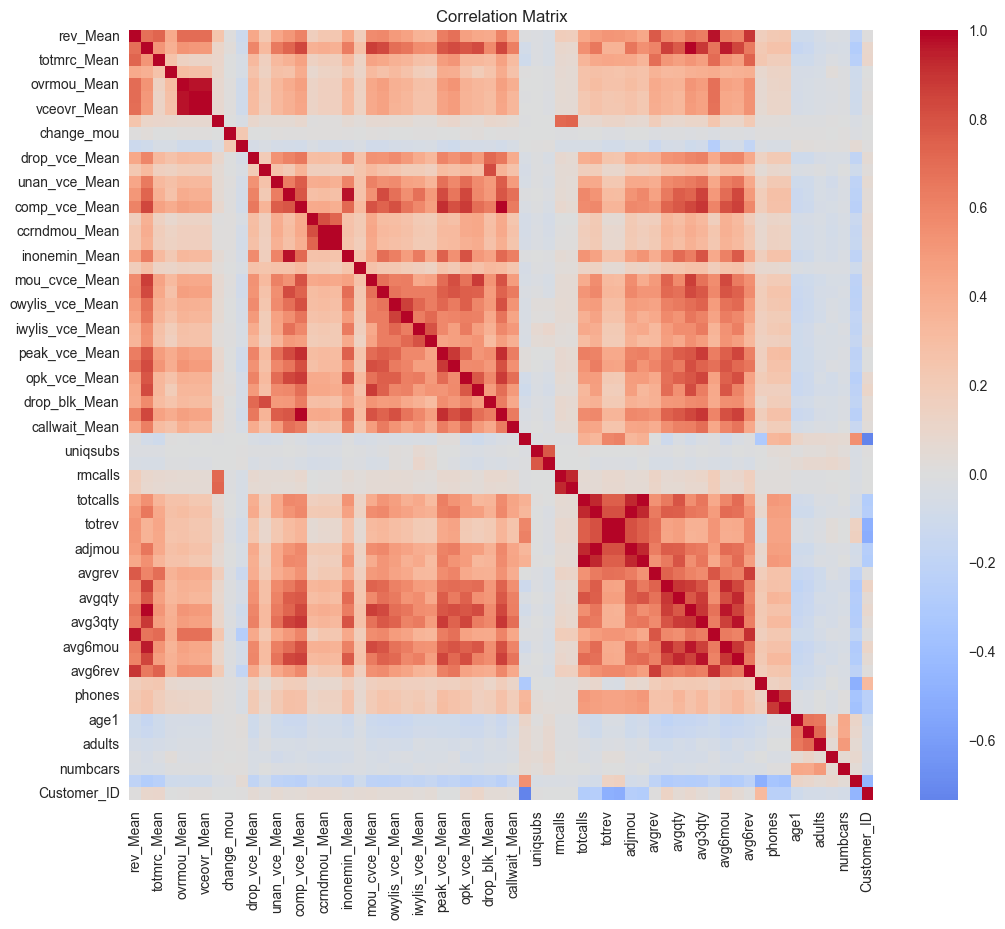

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select numeric columns only
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the matrix
#print(correlation_matrix)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [22]:
columns = df.columns
# Print columns in a list format for better readability
print("List of columns in the DataFrame:")
column_list = list(columns)
for i, col in enumerate(column_list):
    print(f"{i+1}. {col}")

List of columns in the DataFrame:
1. rev_Mean
2. mou_Mean
3. totmrc_Mean
4. da_Mean
5. ovrmou_Mean
6. ovrrev_Mean
7. vceovr_Mean
8. datovr_Mean
9. roam_Mean
10. change_mou
11. change_rev
12. drop_vce_Mean
13. drop_dat_Mean
14. blck_vce_Mean
15. blck_dat_Mean
16. unan_vce_Mean
17. unan_dat_Mean
18. recv_vce_Mean
19. recv_sms_Mean
20. comp_vce_Mean
21. comp_dat_Mean
22. custcare_Mean
23. ccrndmou_Mean
24. cc_mou_Mean
25. inonemin_Mean
26. threeway_Mean
27. mou_cvce_Mean
28. mou_cdat_Mean
29. mou_rvce_Mean
30. owylis_vce_Mean
31. mouowylisv_Mean
32. iwylis_vce_Mean
33. mouiwylisv_Mean
34. peak_vce_Mean
35. peak_dat_Mean
36. mou_peav_Mean
37. mou_pead_Mean
38. opk_vce_Mean
39. opk_dat_Mean
40. mou_opkv_Mean
41. mou_opkd_Mean
42. drop_blk_Mean
43. complete_Mean
44. callfwdv_Mean
45. callwait_Mean
46. churn
47. months
48. uniqsubs
49. actvsubs
50. new_cell
51. crclscod
52. asl_flag
53. rmcalls
54. rmmou
55. totcalls
56. totmou
57. totrev
58. adjrev
59. adjmou
60. adjqty
61. avgrev
62. avgmou

In [23]:
df.to_csv('Churn_Data_cleaned.csv', index=False)
display(df.head())


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,Customer_ID,mail,phoneswap,retentioncall,acptcall,referrals,pcowner_binary,women,mailordr_binary,mailresp_binary
2,16.9900,10.25,16.99,0.0000,0.0,0.0,0.0,False,0.0,-4.25,...,1000003,False,True,False,False,False,True,False,True,True
3,38.0000,7.50,38.00,0.0000,0.0,0.0,0.0,False,0.0,-1.50,...,1000004,False,False,False,False,False,False,False,False,False
4,55.2300,570.50,71.98,0.0000,0.0,0.0,0.0,False,0.0,38.50,...,1000005,False,True,False,False,False,True,False,False,False
6,17.1450,0.00,16.99,0.0000,0.0,0.0,0.0,False,0.0,0.00,...,1000007,False,True,False,False,False,True,False,True,True
9,31.6625,25.50,29.99,0.2475,0.0,0.0,0.0,False,0.0,59.50,...,1000010,False,True,False,False,False,False,False,True,True


<Axes: >

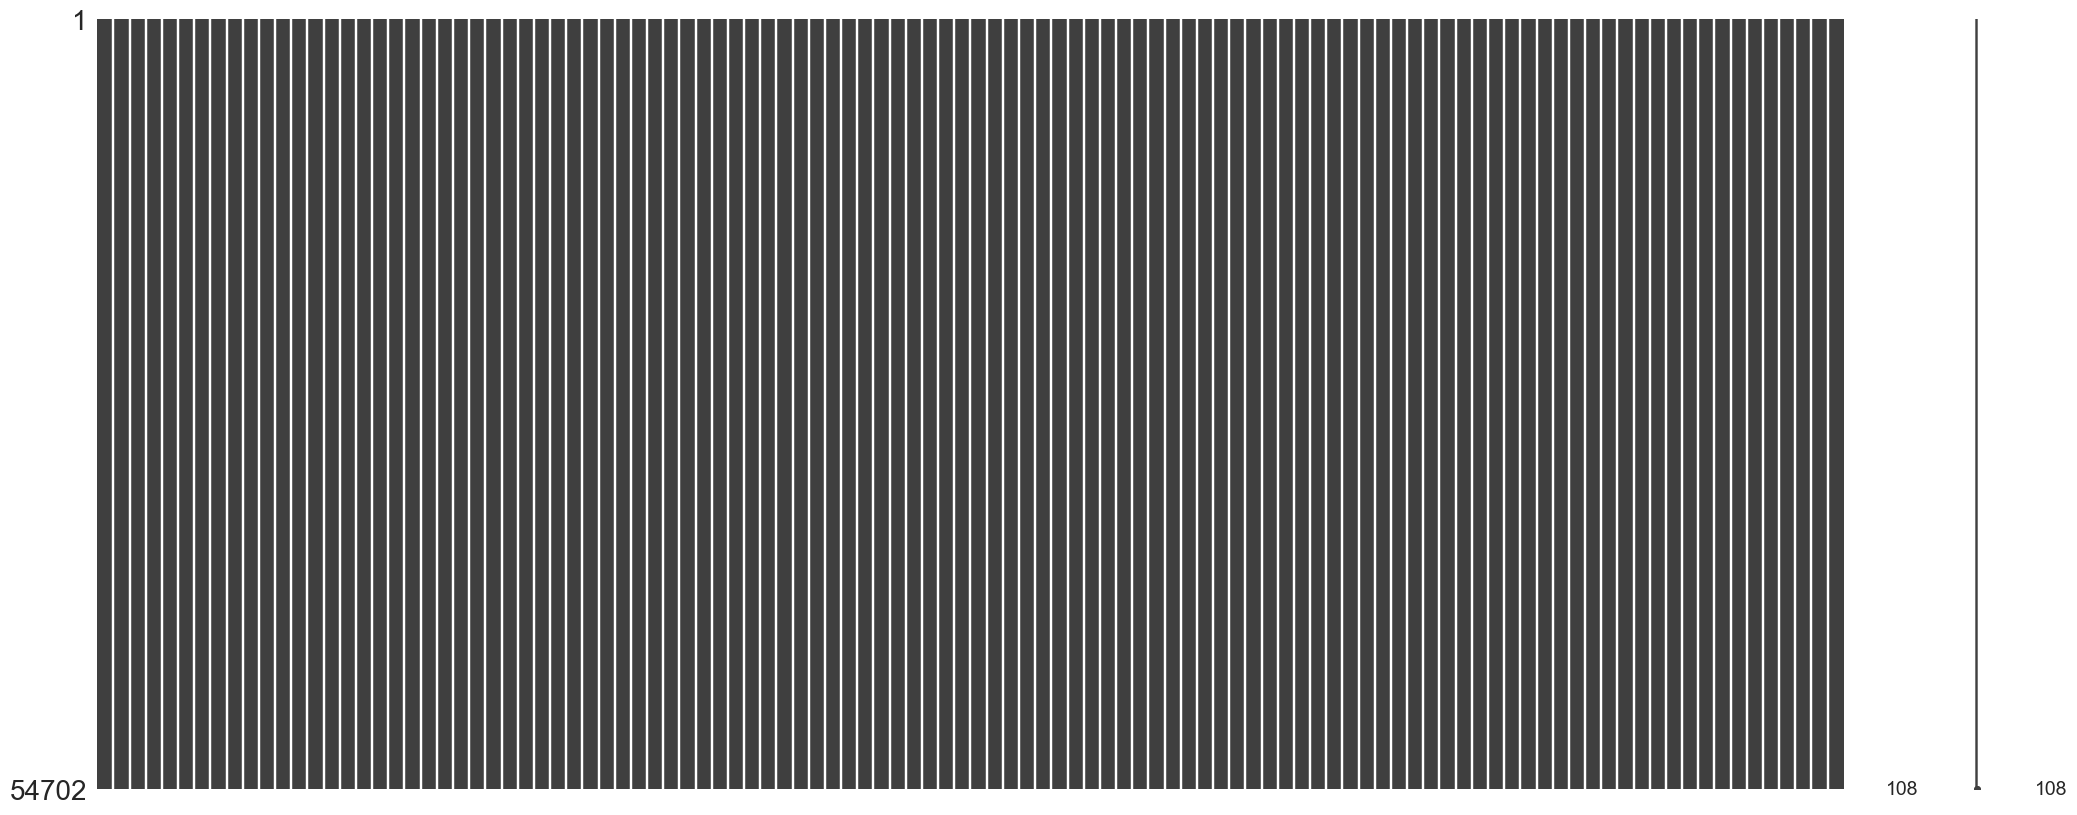

In [24]:
mg.matrix(df)